In [12]:
import dlc_bci as bci
import numpy as np
np.random.seed(5687)
import matplotlib.pyplot as plt
import torch
torch.manual_seed(432)
import random
random.seed(452)
import time
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F

## Import data

In [13]:
big_data = True 
train_input, train_target = bci.load(root ="./data_bci", one_khz=big_data)
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())
test_input, test_target = bci.load(root ="./data_bci", train = False, one_khz=False)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

<class 'torch.Tensor'> torch.Size([316, 28, 500])
<class 'torch.Tensor'> torch.Size([316])
<class 'torch.Tensor'> torch.Size([100, 28, 50])
<class 'torch.Tensor'> torch.Size([100])


## visualize data

Number of training samples = 316
Number of testing samples = 100
Number of channels = 28
Number of readings per channel = 500


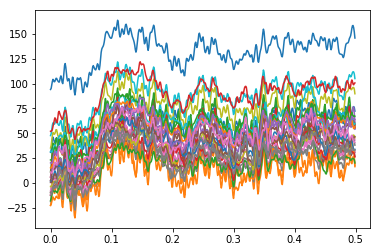

In [14]:
n_train_samples = train_target.size()[0]
print('Number of training samples = {}'.format(n_train_samples))
n_test_samples = test_target.size()[0]
print('Number of testing samples = {}'.format(n_test_samples))
n_channels = train_input.size()[1]
print('Number of channels = {}'.format(n_channels))
n_readings = train_input.size()[2]
print('Number of readings per channel = {}'.format(n_readings))

freq = 2*n_readings

tt = np.arange(0,0.5,1/freq)

for i in range(n_channels):
    plt.plot(tt,train_input[0,i,:].numpy())
    
plt.show()

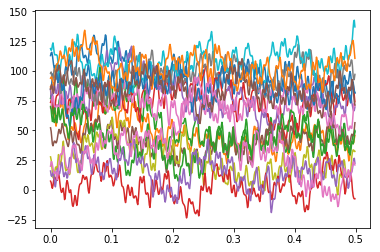

In [15]:
plt.plot(tt,train_input[10:27,8,:].numpy().transpose())
plt.show()

## Augment Data using different sampling shift

In [16]:
def augment_data(train_X, train_Y): 
    
    big_data_set = torch.Tensor(0,28,50)
    big_target = torch.Tensor(0)
    for i in range(10):
        shifted_data = train_X[:,:,i::10]
        big_data_set = torch.cat((big_data_set,shifted_data),0)
        big_target = torch.cat((big_target,train_Y.type(torch.FloatTensor)),0)
    
    return big_data_set, big_target.type(torch.LongTensor)

## Normalize augmented data

In [17]:
train_input = (train_input - torch.mean(train_input,0,keepdim=True))/torch.std(train_input,0,True)
test_input = (test_input - torch.mean(test_input,0,keepdim=True))/torch.std(test_input,0,True)

## Define Network

In [24]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        # Layer 1
        self.conv1a = nn.Conv2d(1, 8, (1, 5), dilation=2) # Apply convolution on each channels
        self.batchnorm1a = nn.BatchNorm2d(8, False) # Normalize

        self.conv1b = nn.Conv2d(8, 16, (1, 5)) # Apply convolution on each channels
        self.batchnorm1b = nn.BatchNorm2d(16, False) # Normalize
        # Layer 2
        self.conv2 = nn.Conv2d(16,32,(28, 1)) # Apply one convolution on each timestamp
        self.batchnorm2 = nn.BatchNorm2d(32, False) # Normalize
             
        # Fully Connected Layers
        self.fc1 = nn.Linear(1216,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,1)
    
    def forward(self, x):

        #print("input shape : {}".format(x.shape))
        x = self.conv1a(x)
        #print("Shape after self.conv1a(x) : {}".format(x.shape))
        x = self.batchnorm1a(x)
        #print("Shape after self.batchnorm1a(x) : {}".format(x.shape))
        x = self.conv1b(x)
        #print("Shape after self.conv1b(x) : {}".format(x.shape))
        x = self.batchnorm1b(x)
        #print("Shape after self.batchnorm1b(x) : {}".format(x.shape))
        x = self.conv2(x)
        x = F.elu(self.batchnorm2(x))
        #print("Shape after secondConvolution : {}".format(x.shape))
        x = F.dropout2d(x,0.5)
        s = x.shape
        a = s[1]*s[2]*s[3] #s[1]*s[2]*s[3] = 32*1*42
        x = x.view(-1,a) 
        #print("Flatten shape for FC : {}".format(x.shape))
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.dropout(x,0.5)
        x = F.elu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #print("Output format : {}".format(x.shape))
        
        return x

In [25]:
class MyNet2(nn.Module):
    def __init__(self):
        super(MyNet2, self).__init__()
        
        self.fc1 = nn.Linear(28*50,128)
        self.fc2 = nn.Linear(128,1)
        
    def forward(self,x):
        
        #print("input shape : {}".format(x.shape))
        x = x.view(-1,28*50)
        #print("Flatten shape for FC : {}".format(x.shape))
        x = F.dropout(x,0.5)
        x = F.relu(self.fc1(x))
        #print(self.fc2(x))
        x = F.sigmoid(self.fc2(x))
        
        return x

In [26]:
class MyNet3(nn.Module):
    def __init__(self):
        super(MyNet3, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 4, (1, 5), dilation=2)
        self.batchnorm1 = nn.BatchNorm2d(4,False)
        self.conv2 = nn.Conv2d(4,4,(28,1))
        self.batchnorm2 = nn.BatchNorm2d(4, False) # Normalize
        self.fc1 = nn.Linear(4*42,64)    
        self.fc2 = nn.Linear(64,1)
        
    def forward(self,x):
        
        #print("input shape : {}".format(x.shape))
        x = self.conv1(x)
        #print("Shape after self.conv1(x) : {}".format(x.shape))
        x = self.batchnorm1(x)
        #print("Shape after self.batchnorm1(x) : {}".format(x.shape))
        x = self.conv2(x)
        #print("Shape after self.conv2(x) : {}".format(x.shape))
        x = self.batchnorm2(x)
        #print("Shape after self.batchnorm2(x) : {}".format(x.shape))
        x = x.view(-1,4*42)
        #print("Flatten shape for FC : {}".format(x.shape))
        x = F.relu(self.fc1(x))
        x = F.dropout(x,0.6)
        #print("after fc1 : {}".format(x.shape))      
        x = F.sigmoid(self.fc2(x))
        
        return x

## Train

In [27]:
def Validation(Y_pred, Y_true):
    return BCE(Y_true,Y_pred)

def N_true(Y_pred, Y_true):
    return torch.sum(torch.round(Y_pred).squeeze()==Y_true.float()).type(torch.FloatTensor)/Y_true.shape[0]
     
def BCE(Y_true,Y_pred):
    
    l = Variable(torch.Tensor(len(Y_true)))
    for i in range(len(Y_true)):
        if(Y_true[i]==1).data.numpy():
            l[i] = - Y_pred[i].log()
        else:
            l[i] = - (1-Y_pred[i]).log() 
        
    return torch.mean(l)

In [53]:
t0 = time.clock()
net = MyNet3()
#optimizer = optim.Adam(net.parameters(), lr=0.00005)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.4)

batch_size = 15
n_max_epochs = 200
n_validation_samples = 160

train_err = []
val_err = []
val_truth = []
train_truth = []

#Prepare validation data
val_idx = random.sample(range(n_train_samples), int(n_validation_samples)) # pick 16 high resolution samples
val_x, val_y = augment_data(train_input[torch.LongTensor(val_idx)],(train_target[torch.LongTensor(val_idx)]))
val_X = Variable(torch.unsqueeze(val_x,1),requires_grad=True)
val_Y = Variable(val_y)

#Prepare training data
train_idx = np.delete(np.arange(len(train_input)),val_idx)
train_x, train_y = augment_data(train_input[torch.LongTensor(train_idx)], train_target[torch.LongTensor(train_idx)])
train_X = Variable(torch.unsqueeze(train_x,1))
train_Y = Variable(train_y)
print("Train shapes \n", train_X.shape, train_Y.shape)

test_x, test_y = test_input, test_target#augment_data(test_input, test_target)
test_X = Variable(torch.unsqueeze(test_x,1))
test_Y = Variable(test_y)
print("Test shapes \n" ,test_X.shape, test_Y.shape)

for epoch in range(n_max_epochs):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    net.train()
    
    train_loss = 0.0
    epoch_true = 0.0
    #print(len(train_X))
    
    for b in range(0, len(train_X), batch_size):   #Train batch by batch
    
        output = net(train_X.narrow(0, b, batch_size))
        loss = BCE(train_Y.narrow(0, b, batch_size),output.squeeze())
        #print(loss)
        net.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
        train_loss = (train_loss + loss.data)/2
        batch_true = N_true(output, train_Y.narrow(0, b, batch_size))
        epoch_true = (epoch_true + batch_true)
        
    net.eval()  
    
    
    val_pred = net(val_X)
    train_err.append(train_loss) #add train loss
    val_err.append(Validation(val_pred,val_Y).data) #add validation loss
    val_truth.append(N_true(val_pred,val_Y)) #add validation accuracy
    print("classification accuracy on validation set: {}".format(val_truth[epoch].data.numpy()))
    train_truth.append(epoch_true/(len(train_input)/batch_size)) #add train accuracy
    print("classification accuracy on training set: {}".format(train_truth[epoch].data.numpy()))
    
    test_pred = net(Variable(torch.unsqueeze(test_input,1)))
#print("Binary Cross Entropy loss for test set: {}".format(BCE(Variable(test_target),test_pred)))
    print("classification accuracy on test set: {}%".format((N_true(net(Variable(torch.unsqueeze(test_input,1))),Variable(test_target)))*100))

    if(abs(train_loss-val_err[epoch])>0.3): 
        '''
        Early Stopping condition if error difference between train and validation too big.
        Train error reduces & Validation error increases -> overfitting'''
        #break
t1 = time.clock()

plt.plot(range(epoch+1),val_err,range(epoch+1),train_err)
plt.legend(['validation error', 'training error'])
plt.show()

print("time for training : ", t1-t0)

Train shapes 
 torch.Size([1560, 1, 28, 50]) torch.Size([1560])
Test shapes 
 torch.Size([100, 1, 28, 50]) torch.Size([100])

Epoch  0
classification accuracy on validation set: 0.5318750143051147
classification accuracy on training set: 2.6360762119293213
classification accuracy on test set: 43.0%

Epoch  1
classification accuracy on validation set: 0.5206249952316284
classification accuracy on training set: 2.9082281589508057
classification accuracy on test set: 45.0%

Epoch  2
classification accuracy on validation set: 0.515625
classification accuracy on training set: 2.9746837615966797
classification accuracy on test set: 43.0%

Epoch  3
classification accuracy on validation set: 0.5143749713897705
classification accuracy on training set: 3.0284812450408936
classification accuracy on test set: 44.0%

Epoch  4
classification accuracy on validation set: 0.5237500071525574
classification accuracy on training set: 3.110759735107422
classification accuracy on test set: 45.0%

Epoch  5
c

KeyboardInterrupt: 

In [ ]:
plt.plot(val_truth)
plt.show()

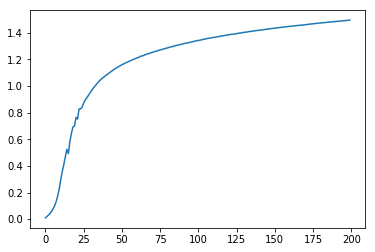

In [30]:
plt.plot(abs(np.asarray(train_err)-np.asarray(val_err)))
plt.show()

In [51]:
x0 = net.conv1(torch.unsqueeze(torch.unsqueeze(train_input[0,:,::10],0),0))
y = net.batchnorm1(x0)
#y = net.conv1b(y)
#y = net.batchnorm1b(y)
#y = net.conv2(y)
#y = net.batchnorm2(y)
y.shape


torch.Size([1, 4, 28, 42])

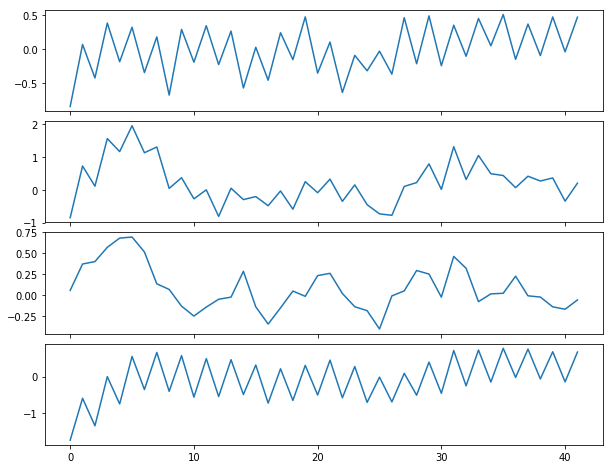

In [52]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10,8))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.1)

# Plot each graph, and manually set the y tick values
for j in range(4):
    axs[j].plot(y.detach().numpy()[0,j,0,:])
    
plt.show()
fig.savefig('layer2_net3.png')